# **Landfill Environmental Justice Data Story**

This notebook performs an analysis on Landfill plumes from EMIT data for Dallas, Texas and Stockton, California. The goal is to explore and visualize the data, understand its distribution, and identify any overlaps between the plumes and socioeconomic status using census data from the CDC.

Data Sources:

Greenhouse Gas Center (Where EMIT is Housed): https://earth.gov/ghgcenter

SVI: https://www.atsdr.cdc.gov/placeandhealth/svi/index.html

# **Import and Install Necessary Packages**

In [1]:
!pip install -q rasterstats
!pip install -q pyogrio
!pip install -q rasterstats

# The following packages are already included in the Jupyterhub:
# !pip install -q geopandas 
# !pip install -q rasterio
# !pip install -q cartopy

In [2]:
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.plot import show
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import folium
from folium.features import DivIcon

# **Read and Plot Dallas, TX Plumes**

This section contains code to read and visualize Methane plumes over Dallas, Texas.

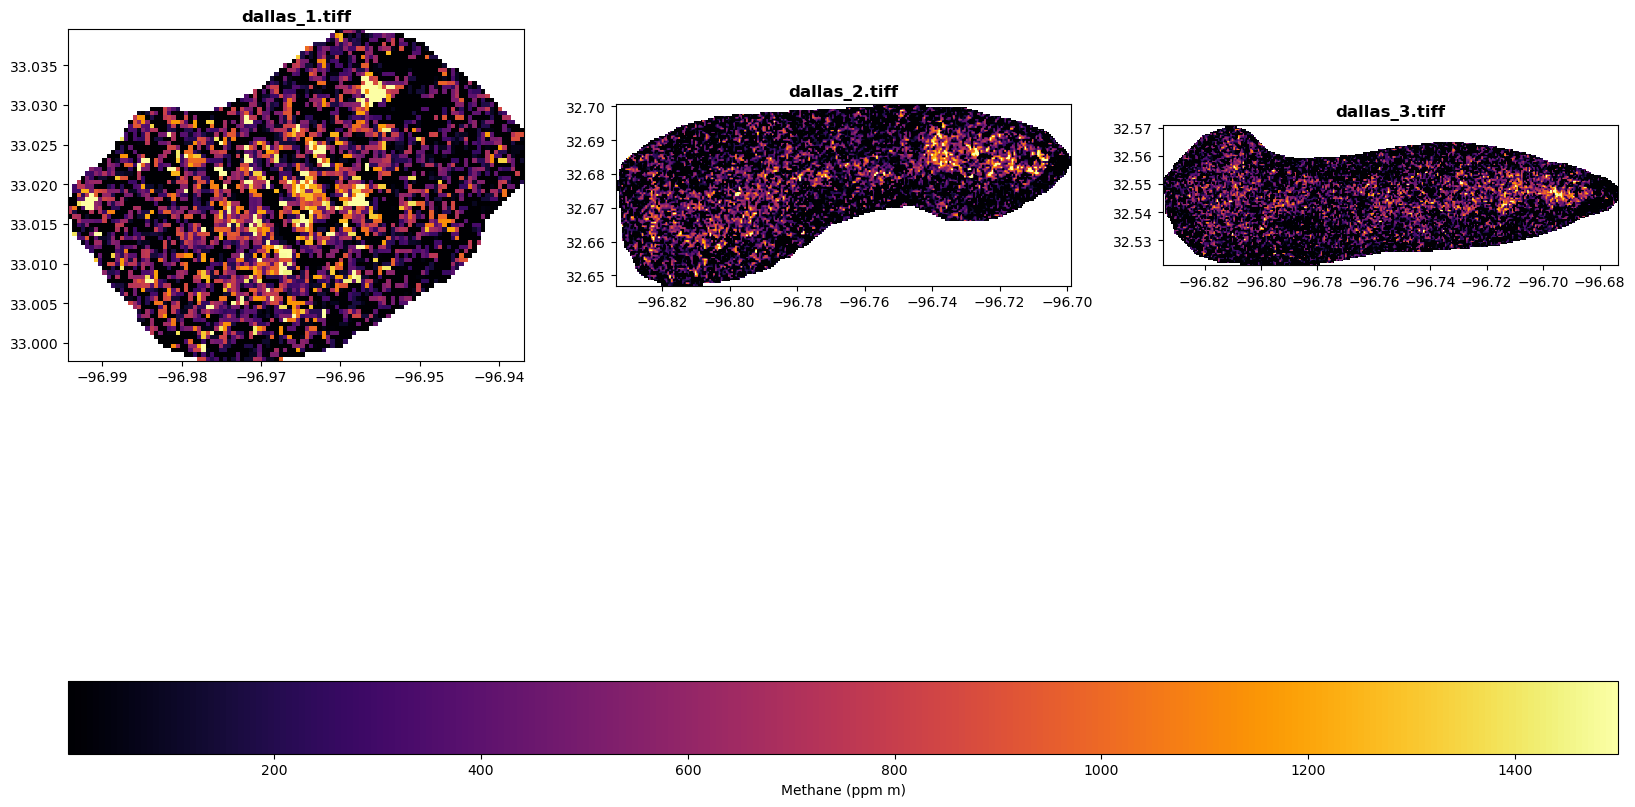

In [3]:
# File paths
file_paths = [
    '../shared/esip/landfill/dallas_1.tiff',
    '../shared/esip/landfill/dallas_2.tiff',
    '../shared/esip/landfill/dallas_3.tiff']

# Set the desired min and max values for rescaling
vmin, vmax = 1, 1500

# Create a figure with subplots
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[10, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Plot each TIFF file with 'inferno' colormap
for ax, file_path in zip(axes, file_paths):
    with rasterio.open(file_path) as src:
        img = show(src, ax=ax, cmap='inferno', vmin=vmin, vmax=vmax, title=file_path.split('/')[-1])

# Create a colorbar
cbar_ax = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(img.get_images()[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Methane (ppm m)')

plt.show()

# **CDC SVI data from 2020 for Texas**

This section contains code that reads in the census data and plots the overall Texas SVI and the counties of interest with Dallas and Fort Worth annotated. We also annotated where the methane plumes are located.

In [4]:
texas_svi = "/vsizip/../shared/esip/landfill/SVI2020_TEXAS_tract.gdb-20240708T190903Z-001.zip/SVI2020_TEXAS_tract.gdb"
texas_svi = gpd.read_file(texas_svi, engine = 'pyogrio')

<Figure size 1000x600 with 0 Axes>

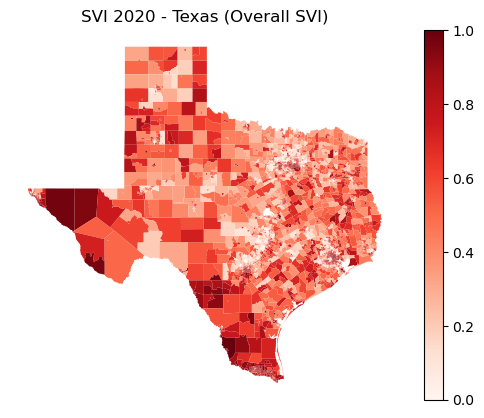

In [5]:
state_name = 'Texas'
column_to_plot = 'RPL_THEMES'

# Filter the DataFrame for Texas
texas_svi = texas_svi[texas_svi['STATE'] == state_name]

# Remove invalid values
texas_svi = texas_svi[texas_svi[column_to_plot] != -999]

# Plot the overall SVI for Texas with a sequential color map
plt.figure(figsize=(10, 6))
texas_svi.plot(column=column_to_plot, legend=True, cmap='Reds', vmin=0, vmax=1)
plt.title('SVI 2020 - Texas (Overall SVI)')
plt.axis('off')
plt.show()

In [11]:
# Filter for Dallas, Tarrant, and surrounding counties
counties = texas_svi[(texas_svi['COUNTY'] == 'Dallas') | (texas_svi['COUNTY'] == 'Tarrant') |
                     (texas_svi['COUNTY'] == 'Collin') | (texas_svi['COUNTY'] == 'Denton') |
                     (texas_svi['COUNTY'] == 'Johnson') | (texas_svi['COUNTY'] == 'Ellis')]

# Simplify the geometries to reduce rendering load
counties['geometry'] = counties['geometry'].simplify(tolerance=0.01)

# Central coordinates of the plume TIFFs
plume_coords = [
    (-96.96554886988591, 33.01865445063364),
    (-96.76627841869168, 32.67379456775059),
    (-96.75407818698592, 32.546098809230216)
]

# Create a base map centered around Dallas-Fort Worth
m = folium.Map(location=[32.7767, -96.7969], zoom_start=10)

# Define a colormap with Reds
colormap = folium.LinearColormap(colors=['#fff5f0', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#67000d'], vmin=0, vmax=1)

# Function to style each feature
def style_function(feature):
    return {
        'fillColor': colormap(feature['properties'][column_to_plot]),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.6,  # Adjust transparency here
    }

# Add the GeoJSON to the map
folium.GeoJson(
    counties,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=[column_to_plot], aliases=['SVI: ']),
).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Add annotations for Dallas and Fort Worth
folium.Marker(
    location=[32.7767, -96.7969],
    popup='Dallas',
    icon=folium.DivIcon(
        html=f"""<div style="font-size: 12px; color: black;">Dallas</div>"""
    )
).add_to(m)

folium.Marker(
    location=[32.7555, -97.3308],
    popup='Fort Worth',
    icon=folium.DivIcon(
        html=f"""<div style="font-size: 12px; color: black;">Fort Worth</div>"""
    )
).add_to(m)

# Annotate the central coordinates of the plume TIFFs
for i, coords in enumerate(plume_coords):
    folium.Marker(
        location=[coords[1], coords[0]],
        popup=f'Plume {i+1}',
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12px; color: black;">Plume {i+1}</div>"""
        )
    ).add_to(m)
    folium.CircleMarker(
        location=[coords[1], coords[0]],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# **Read and Plot Stockton, CA Plumes**

This section contains code to read and visualize Methane plumes over Stockton, California.

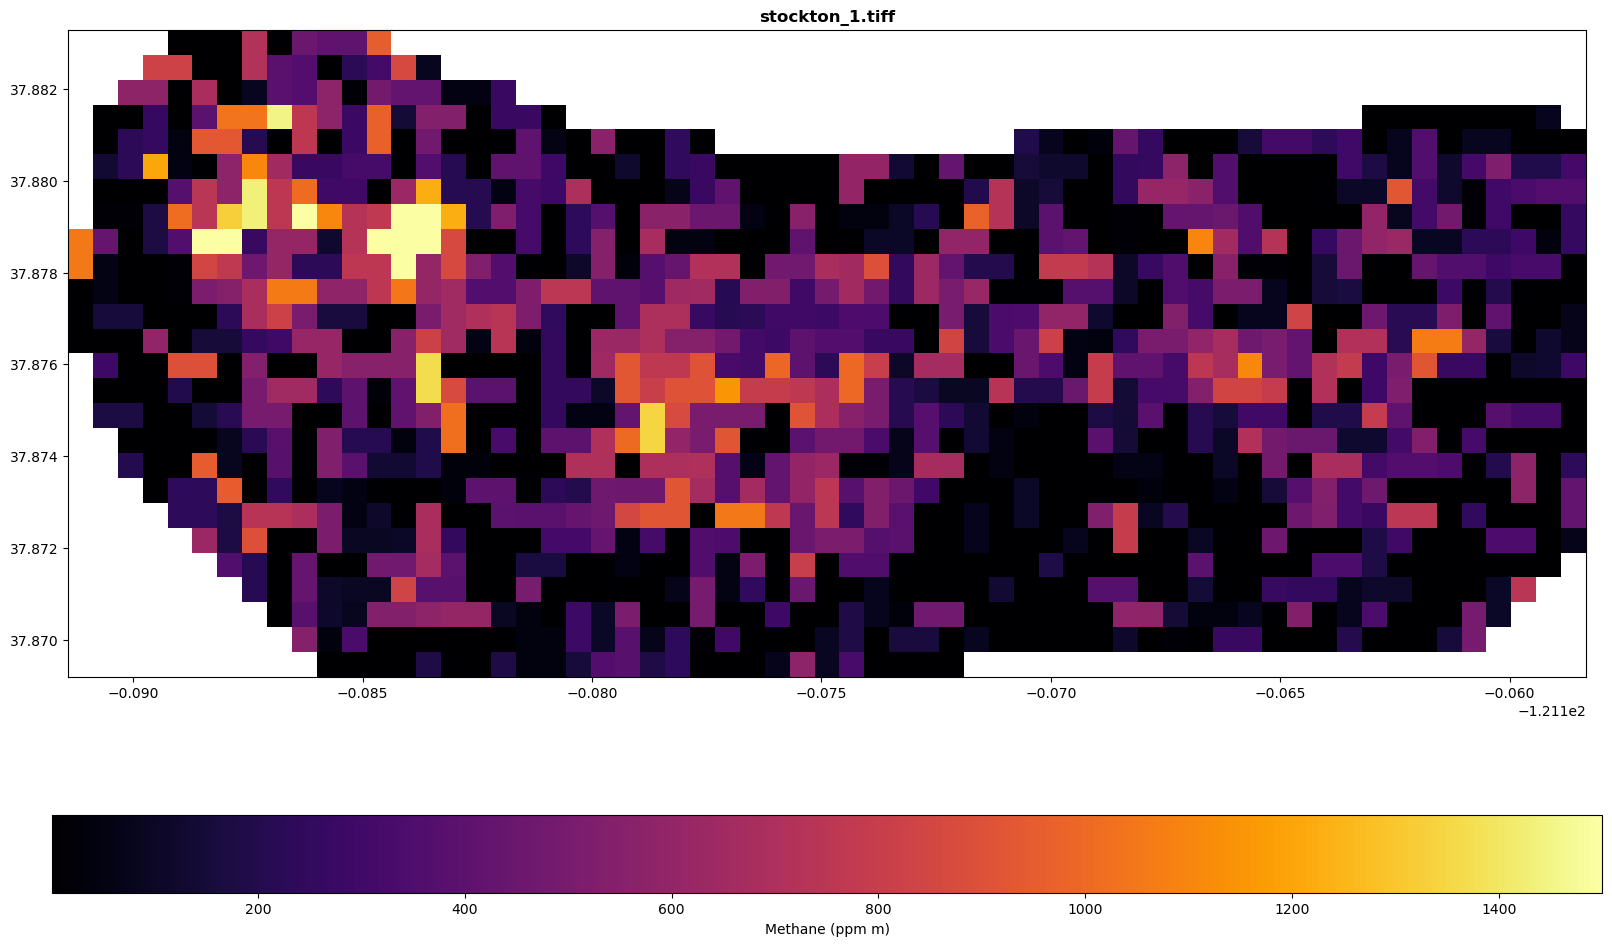

In [7]:
# File path
file_path = 'data/stockton_1.tiff'

# Set the desired min and max values for rescaling
vmin, vmax = 1, 1500

# Create a figure
fig, ax = plt.subplots(figsize=(20, 12))

# Plot the TIFF file with 'inferno' colormap
with rasterio.open(file_path) as src:
    img = show(src, ax=ax, cmap='inferno', vmin=vmin, vmax=vmax, title=file_path.split('/')[-1])

# Create a colorbar
cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation='horizontal')
cbar.set_label('Methane (ppm m)')

plt.show()

# **CDC SVI data from 2020 for California**

This section contains code that reads in the census data and plots the overall California SVI and the counties of interest with Stockton annotated. We also annotated where the methane plumes are located.

In [8]:
california_svi = '/vsizip/../shared/esip/landfill/SVI2020_CALIFORNIA_tract.gdb-20240708T190206Z-001.zip/SVI2020_CALIFORNIA_tract.gdb'
california_svi = gpd.read_file(california_svi, engine = 'pyogrio')

<Figure size 1000x600 with 0 Axes>

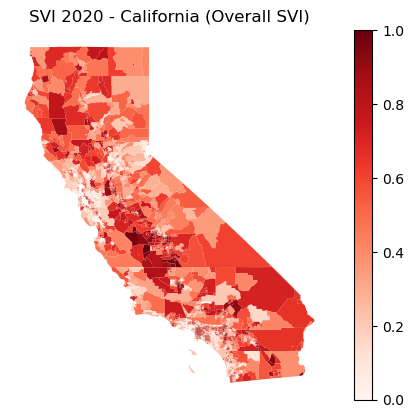

In [9]:
state_name = 'California'
column_to_plot = 'RPL_THEMES'

california_svi = california_svi[california_svi['STATE'] == state_name]

california_svi = california_svi[california_svi[column_to_plot] != -999]

plt.figure(figsize=(10, 6))
california_svi.plot(column=column_to_plot, legend=True, cmap='Reds', vmin=0, vmax=1)
plt.title('SVI 2020 - California (Overall SVI)')
plt.axis('off')
plt.show()

In [12]:
# Filter for San Joaquin County
san_joaquin_svi = california_svi[california_svi['COUNTY'] == 'San Joaquin']

# Remove invalid values
san_joaquin_svi = san_joaquin_svi[san_joaquin_svi[column_to_plot] != -999]

# Simplify the geometries to reduce rendering load
san_joaquin_svi['geometry'] = san_joaquin_svi['geometry'].simplify(tolerance=0.01)

# Central coordinates of the plume TIFF
central_coords = (-121.17487531803246, 37.87624448335031)

# Stockton coordinates
stockton_coords = (-121.2908, 37.9577)

# Create a base map centered around San Joaquin County
m = folium.Map(location=[37.9577, -121.2908], zoom_start=10)

# Define a colormap with Reds
colormap = folium.LinearColormap(colors=['#fff5f0', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#67000d'], vmin=0, vmax=1)

# Function to style each feature
def style_function(feature):
    return {
        'fillColor': colormap(feature['properties'][column_to_plot]),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.6,  # Adjust transparency here
    }

# Add the GeoJSON to the map
folium.GeoJson(
    san_joaquin_svi,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=[column_to_plot], aliases=['SVI: ']),
).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Add annotations for Stockton
folium.Marker(
    location=[37.9577, -121.2908],
    popup='Stockton',
    icon=folium.DivIcon(
        html=f"""<div style="font-size: 12px; color: black;">Stockton</div>"""
    )
).add_to(m)

# Annotate the central coordinates of the plume TIFF
folium.Marker(
    location=[37.87624448335031, -121.17487531803246],
    popup='Plume',
    icon=folium.DivIcon(
        html=f"""<div style="font-size: 12px; color: black;">Plume</div>"""
    )
).add_to(m)
folium.CircleMarker(
    location=[37.87624448335031, -121.17487531803246],
    radius=5,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6
).add_to(m)

# Display the map
m

# **Summary**

In this notebook, we performed an analysis on the EMIT Plume data and SVI for Dallas, TX and Stockton, CA. We explored the data by visualizing key locations with lower socioeconomic status and plumes annotated.